# ISC data preparation
- In this notebook, I clean the dataset retrieved from the ISC-EHB catalog. 
- This is similar to the code in other_areas, but decided to separate this as the core processes are different
- Run this with the proj1 environment
- This notebook was prepared specifically for working with Australian seismicity

In [67]:
import numpy as np
import pandas as pd
import json, re, sys, math
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime # this is a very convenient function!
import cartopy
from pathlib import Path
from datetime import datetime

import cartopy as cartopy
import cartopy.mpl.ticker as cticker 
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "helvetica"
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import vis_pkg
import slab_data_mani

sys.path.append('seismo/src')
#from stat_seismo import *

%matplotlib inline

In [48]:
""" Parameters here """
#diff_thresh = 20 # megathrust interface threshold
out_suffix = "aus"

isc_fname = "/Users/jgra0019/Documents/phd_data/aus_fm/aus_nsha2018_raw.csv"

isc_df = pd.read_csv(isc_fname, header = 'infer')


# A. Earthquake catalog preparation

In [65]:
# print('Before dropping duplicate events: ')
# print(isc_df.shape)

# #isc_df = isc_df.drop_duplicates(subset='EVENTID', keep = 'last') # keep last (probably updates)

# print('After dropping duplicate events: ')
# print(isc_df.shape)

Before dropping duplicate events: 
(12551, 29)
After dropping duplicate events: 
(12551, 29)


In [66]:
#isc_df = isc_df[isc_df.DEPQUAL.isin(['L1', 'L2'])] # remove the events with large uncertainty
# isc_df = isc_df.reset_index(drop=True)
# print("Events left after dropping L3 depths.")
# print(isc_df.shape)

Events left after dropping L3 depths.
(12551, 29)


## Check distribution of Mw

(array([ 37.,  51.,  44.,  29.,   8.,  14.,   8.,   5.,   4.,   1.]),
 array([ 2.76 ,  3.194,  3.628,  4.062,  4.496,  4.93 ,  5.364,  5.798,
         6.232,  6.666,  7.1  ]),
 <BarContainer object of 10 artists>)

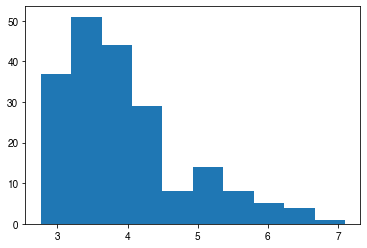

In [49]:
plt.hist(isc_df["PREFMW"])

In [50]:
isc_df.shape

(12551, 29)

In [33]:
isc_df["PREFMW"].max()

7.1

## Read the topography

In [28]:
topo_fname = "/Users/jgra0019/Documents/phd_research/data/topography/aus_region.grd"
lon, lat, elev, topo_hs = vis_pkg.process_topo(topo_fname, vmin = -6000, vmax = 2000)

Reading  /Users/jgra0019/Documents/phd_research/data/topography/aus_region.grd
['Conventions', 'history', 'GMT_version', 'node_offset']
['lon', 'lat']
['lon', 'lat', 'z']


In [29]:
# delete the rows with null
# isc_df = isc_df[~row_has_NaN]
# isc_df.shape

# add a column called VAL - just so we can use the seismicity with the vis_pkg
isc_df["VAL"] = 1

isc_df = isc_df.reset_index(drop = True, inplace = False)

## Data before we continue processing

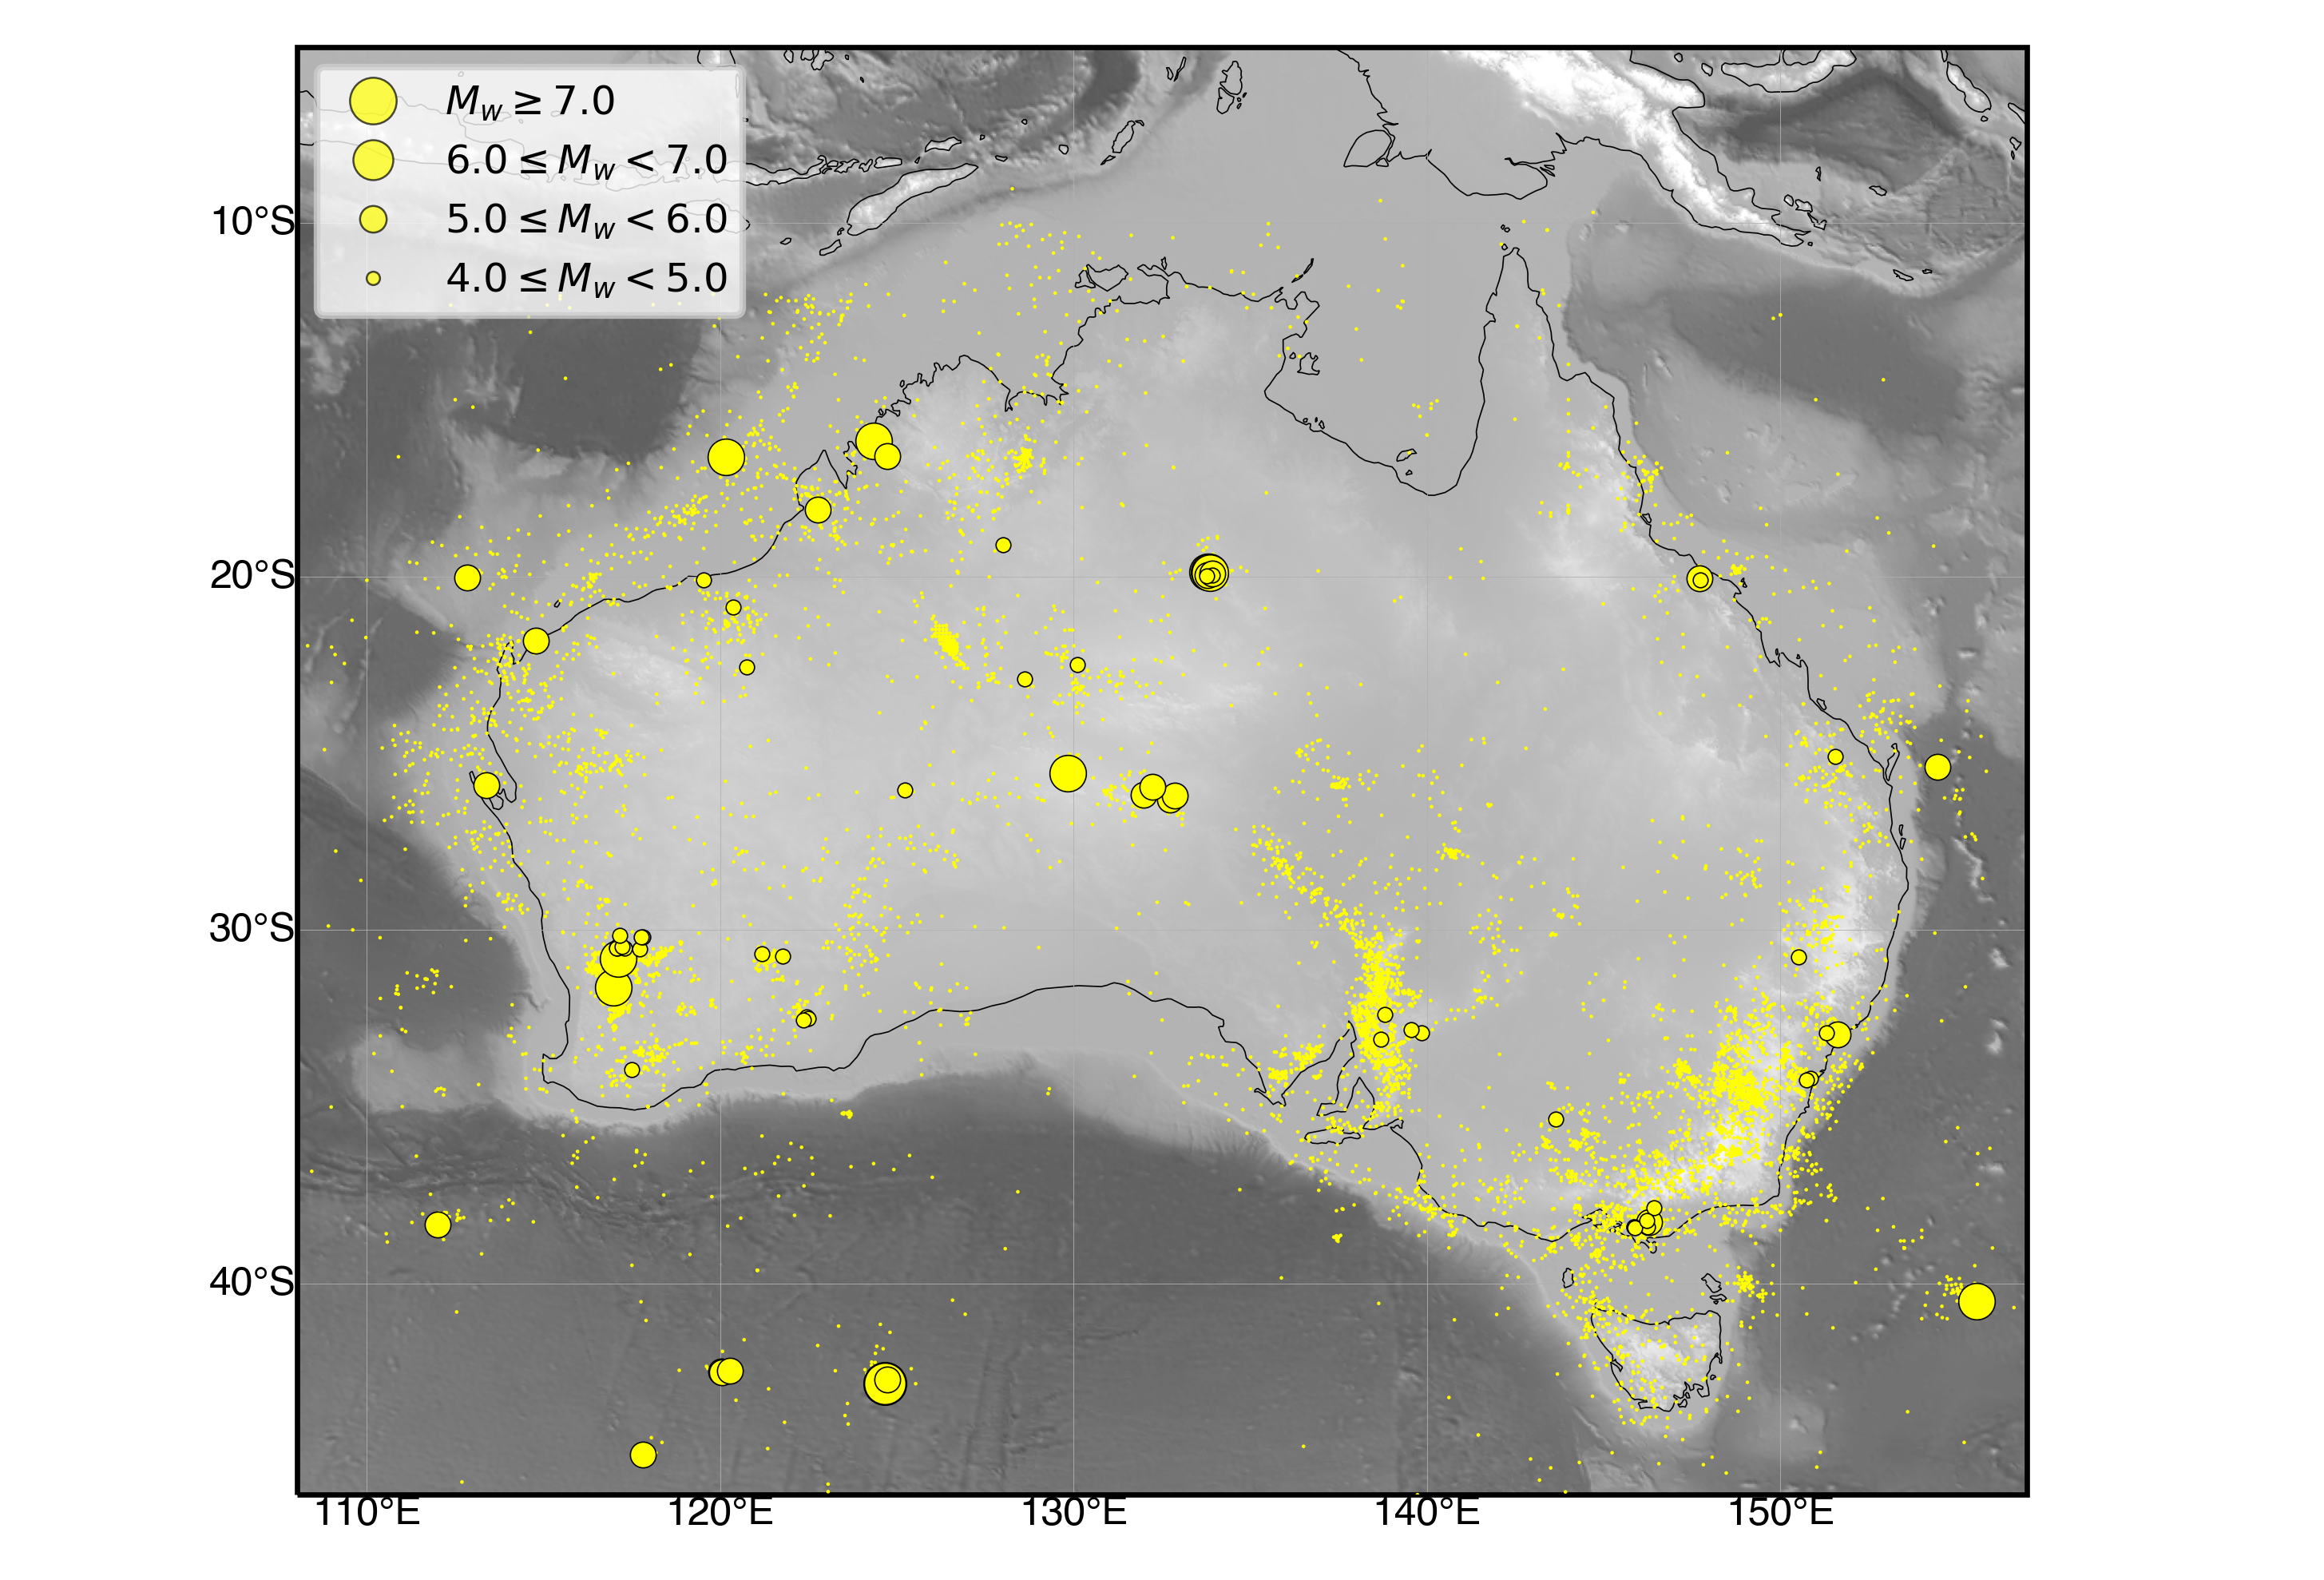

In [95]:
mapper = vis_pkg.Mapper(data = None,
                        dpi = 600, 
                        topo = {'LON': lon, 'LAT': lat, 'VAL': topo_hs},
                        extent = [107, 158, -47, -4], # data extent has higher priority
                        dim_inch = None
                        )
mapper.create_basemap()
mapper.add_topo()

# for the earthquakes 
mapper.ax.scatter(isc_df['LON'], isc_df['LAT'], marker = 'o', c = "yellow", 
                            s = 0.3, edgecolors = 'none', transform=ccrs.PlateCarree(), zorder = 3)
cond = (isc_df["PREFMW"] >= 4) & (isc_df["PREFMW"] < 5)
mapper.ax.scatter(isc_df[cond]['LON'], isc_df[cond]['LAT'], marker = 'o', c = "yellow", 
                            s = 5, edgecolors = 'k', linewidths = 0.2, transform=ccrs.PlateCarree(), zorder = 6)
cond = (isc_df["PREFMW"] >= 5) & (isc_df["PREFMW"] < 6)
mapper.ax.scatter(isc_df[cond]['LON'], isc_df[cond]['LAT'], marker = 'o', c = "yellow", 
                            s = 15, edgecolors = 'k', linewidths = 0.2, transform=ccrs.PlateCarree(), zorder = 5)
cond = (isc_df["PREFMW"] >= 6) & (isc_df["PREFMW"] < 7)
mapper.ax.scatter(isc_df[cond]['LON'], isc_df[cond]['LAT'], marker = 'o', c = "yellow", 
                            s = 30, edgecolors = 'k', linewidths = 0.2, transform=ccrs.PlateCarree(), zorder = 4)
cond = (isc_df["PREFMW"] >= 7)
mapper.ax.scatter(isc_df[cond]['LON'], isc_df[cond]['LAT'], marker = 'o', c = "yellow", 
                            s = 40, edgecolors = 'k', linewidths = 0.3, transform=ccrs.PlateCarree(), zorder = 3)

size = [7, 6, 4, 2]
labels = [r'$M_w \geq 7.0$', r'$6.0 \leq M_w < 7.0$', r'$5.0 \leq M_w < 6.0$', r'$4.0 \leq M_w < 5.0$']
lines = [Line2D([0], [0], markersize = s, color = 'yellow', marker = 'o', alpha = 0.7, linewidth = 0, markeredgewidth = 0.3, markeredgecolor = 'k') for s in size]
leg = mapper.ax.legend(lines, labels, loc = 'upper left', fontsize = 6, title = '', title_fontsize = 8)
leg._legend_box.align = "left"
for lh in leg.legendHandles: 
    lh.set_alpha(1)
